# SIR SEIR Comparison

## SIR Model

\begin{cases}
    \frac{dS}{dt} = -\frac{\beta S I}{N} \\
    \frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
    \frac{dR}{dt} = \gamma I
\end{cases}

$$
N = S + I + R
$$

## SEIR Model

\begin{cases}
    \frac{dS}{dt} = -\frac{\beta S I}{N} \\
    \frac{dE}{dt} = \frac{\beta S I}{N} - \sigma E \\
    \frac{dI}{dt} = \sigma E - \gamma I \\
    \frac{dR}{dt} = \gamma I
\end{cases}

$$
N = S + E + I + R
$$

## Parameters

And parameters are:

- $\beta$ is infection rate or the rate of spread

- $\sigma$ is the incubation rate or the rate of latent individuals becoming infectious (average duration of incubation is $1/\sigma$)

- $\gamma$ is the recovery rate or mortality rate. If the duration of indection is D then $\gamma$ = 1/D

## Modules and Settings

In [151]:
# Import modules

import os                as os
import warnings

import sys
import time
import arviz             as az
import numpy             as np
import pandas            as pd

import pymc3             as pm
import theano
import theano.tensor     as tt

import matplotlib.pyplot as plt

from scipy.integrate   import odeint
from scipy.interpolate import interp1d

# Further technicalities

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")

# Checking versions

print(f"Theano version: {theano.__version__}")
print(f"PyMC3  version: {pm.__version__}")

Theano version: 1.1.2
PyMC3  version: 3.11.4


In [152]:
# System

stochastic  = False          # random seeds for the experiments

RANDOM_SEED = 123456         # sampling seed
NUMPY_SEED  = 123            # Numpy seed



# Plot 1

plot_1 = True                # Compare SIR and SEIR for given values of parameters and initial conditions



# Plot 2

plot_2 = True                # Plot likelihood of SIR data wrt SEIR data

n_ref_lik       = 50
contour_lik     = 20

lower_beta      =  0.1
upper_beta      =  1.5

lower_gamma     =  0.2
upper_gamma     =  0.7

noise_var_plot2 =  0.1





# SIR

noise_variance_SIR = 0.0000001

## Initial conditions

initN_SIR = 1.

initI_SIR = 0.1
initR_SIR = 0.


## True values for the parameters

gamma_true_SIR = 0.5
beta_true_SIR  = 1.1

## Days and steps

days_SIR      =  50                            
time_step_SIR =   0.5       



# SEIR

noise_variance_SEIR = noise_variance_SIR

## Initial conditions

initN_SEIR = 1.

initE_SEIR = 0.
initI_SEIR = 0.1
initR_SEIR = 0.

## True values for the parameters

sigma_true_SEIR = 1.2
gamma_true_SEIR = 0.5
beta_true_SEIR  = 1.1

## Days and steps

days_SEIR      =  days_SIR
time_step_SEIR =   0.5

## Dynamical Systems

In [153]:
# SIR

def ode_model_SIR(z, t, beta, gamma):
    S, I, R = z
    N = S + I + R
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

def ode_solver_SIR(t, initial_conditions, params):
  initI, initR, initN = initial_conditions
  beta, gamma = params
  initS = initN - (initI + initR)
  res = odeint(ode_model_SIR, [initS, initI, initR], t, args=(beta, gamma))
  return res

# SEIR

def ode_model_SEIR(z, t, beta, sigma, gamma):

    S, E, I, R = z
    N = S + E + I + R
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I
    dRdt = gamma*I
    return [dSdt, dEdt, dIdt, dRdt]

def ode_solver_SEIR(t, initial_conditions, params):
  initE, initI, initR, initN = initial_conditions
  beta, sigma, gamma = params
  initS = initN - (initE + initI + initR)
  res = odeint(ode_model_SEIR, [initS, initE, initI, initR], t, args=(beta, sigma, gamma))
  return res

## Model Objects

In [154]:
# SIR True

class Dynamical_System_SIR():

  def __init__(self, gamma_true, beta_true, days, time_step, initN, initI, initR, noise_scale):
    
    # Set the quantities related to the true system

    self.gamma = gamma_true
    self.beta = beta_true

    # Initial conditions

    self.initN = initN
    self.initI = initI
    self.initR = initR

    self.initial_conditions = [initI, initR, initN]
    self.params = [self.beta, self.gamma]

    # Set time discretization grid

    self.time_grid = np.arange(0, days+time_step, time_step)

    # Compute solution

    self.sol = ode_solver_SIR(self.time_grid, self.initial_conditions, self.params)

    # Save solutions and add noise
    
    self.I = self.sol[:,1] + np.random.normal(0,noise_scale, len(self.time_grid))
    self.R = self.sol[:,2] + np.random.normal(0,noise_scale, len(self.time_grid))
    
    # Save objects for interpolation

    self.I_interpolated = interp1d(self.time_grid, self.I, kind = "linear")
    self.R_interpolated = interp1d(self.time_grid, self.R, kind = "linear")

    self.data = np.column_stack((self.I, self.R))

  def plot_model(self):

    SIR_cmap = plt.cm.get_cmap('Set1', 3)(range(3))
    
    plt.plot(self.time_grid, self.I, label = "I  (SIR)", color = SIR_cmap[1])
    plt.plot(self.time_grid, self.R, label = "R (SIR)",  color = SIR_cmap[2])

    plt.xlabel('time [d]')
    plt.ylabel('population [%]')



# SIR Forward

class Dynamical_System_Forward_SIR(Dynamical_System_SIR):

  def __init__(self, days, time_step, initN, initI, initR):

    # Initial conditions

    self.initN = initN
    self.initI = initI
    self.initR = initR

    self.initial_conditions = [initI, initR, initN]

    # Set time discretization grid

    self.time_grid = np.arange(0, days+time_step, time_step)

  def solve(self, beta_random, gamma_random):

    self.sol = ode_solver_SIR(self.time_grid, self.initial_conditions, [beta_random, gamma_random])

    self.S_interpolated = interp1d(self.time_grid, self.sol[:,0], kind = "linear")
    self.I_interpolated = interp1d(self.time_grid, self.sol[:,1], kind = "linear")
    self.R_interpolated = interp1d(self.time_grid, self.sol[:,2], kind = "linear")

  def plot_model(self):

    SIR_cmap = plt.cm.get_cmap('Set1', 3)(range(3))

    plt.plot(self.time_grid, self.sol[:,1], label = "I  (SIR)", color = SIR_cmap[1])
    plt.plot(self.time_grid, self.sol[:,2], label = "R (SIR)",  color = SIR_cmap[2])

    plt.xlabel('time [d]')
    plt.ylabel('population [%]')

  def sol_interpolated(self, times):
    return np.transpose(np.array([self.I_interpolated(times), self.R_interpolated(times)]))



# SEIR True

class Dynamical_System_SEIR():

  def __init__(self, sigma_true, gamma_true, beta_true, days, time_step, initN, initE, initI, initR, noise_scale):
    
    # Set the quantities related to the true system

    self.sigma = sigma_true
    self.gamma = gamma_true
    self.beta = beta_true

    # Initial conditions

    self.initN = initN
    self.initE = initE
    self.initI = initI
    self.initR = initR

    self.initial_conditions = [initE, initI, initR, initN]
    self.params = [self.beta, self.sigma, self.gamma]

    # Set time discretization grid

    self.time_grid = np.arange(0, days+time_step, time_step)

    # Compute solution

    self.sol = ode_solver_SEIR(self.time_grid, self.initial_conditions, self.params)

    # Save solutions and add noise
    
    self.E = self.sol[:,1] + np.random.normal(0,noise_scale, len(self.time_grid))
    self.I = self.sol[:,2] + np.random.normal(0,noise_scale, len(self.time_grid))
    self.R = self.sol[:,3] + np.random.normal(0,noise_scale, len(self.time_grid))

    # Save objects for interpolation

    self.E_interpolated = interp1d(self.time_grid, self.E, kind = "linear")
    self.I_interpolated = interp1d(self.time_grid, self.I, kind = "linear")
    self.R_interpolated = interp1d(self.time_grid, self.R, kind = "linear")

    self.data = np.column_stack((self.I, self.R))

  def plot_model(self):

    SEIR_cmap = plt.cm.get_cmap('Set3', 4)(range(4))

    plt.plot(self.time_grid, self.E, label = "E (SEIR)",  color = SEIR_cmap[1])
    plt.plot(self.time_grid, self.I, label = "I  (SEIR)", color = SEIR_cmap[2])
    plt.plot(self.time_grid, self.R, label = "R (SEIR)",  color = SEIR_cmap[3])

    plt.xlabel('time [d]')
    plt.ylabel('population [%]')

## Plot 1: Compare SIR and SEIR solutions

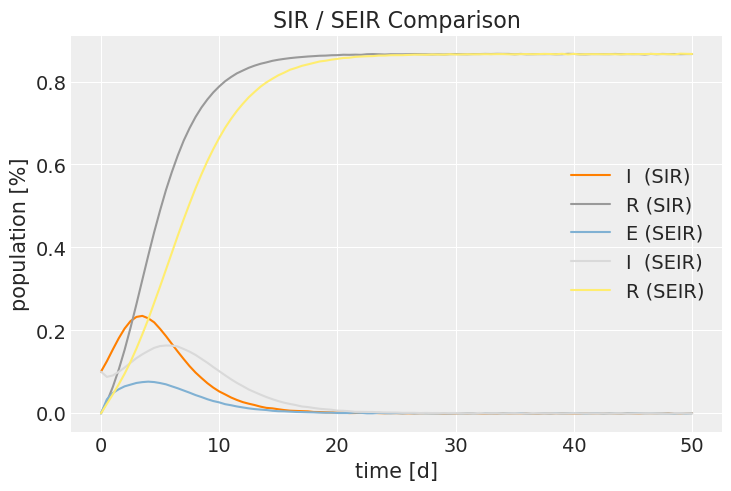

In [155]:
# Initialise a SIR Model

model_true_SIR = Dynamical_System_SIR(gamma_true_SIR, beta_true_SIR, 
                                      days_SIR, time_step_SIR, 
                                      initN_SIR, initI_SIR, initR_SIR, 
                                      np.sqrt(noise_variance_SIR))

# Initialize a SEIR Model

model_true_SEIR = Dynamical_System_SEIR(sigma_true_SEIR, gamma_true_SEIR, beta_true_SEIR, 
                                        days_SEIR, time_step_SEIR, 
                                        initN_SEIR, initE_SEIR, initI_SEIR, initR_SEIR, 
                                        np.sqrt(noise_variance_SEIR))

# Plot the 2 solutions

plt.figure()

model_true_SIR .plot_model()
model_true_SEIR.plot_model()

plt.title('SIR / SEIR Comparison')
plt.legend(loc="best")

plt.show()

## Plot 2: Likelihood of SIR solution wrt SEIR solution

In [156]:
# Define log likelihood

def my_loglik(my_model, beta_random, gamma_random, noise_variance_random, model_true):
    
  my_model.solve(beta_random, gamma_random)
    
  return -np.sum(np.linalg.norm(my_model.sol_interpolated(model_true.time_grid) - model_true.data, axis = 1)**2)/ (2 * noise_variance_random)

/var/folders/zh/jv1b2t351dx2rqz29grjnb_r0000gn/T/ipykernel_15236/3097401511.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sf)


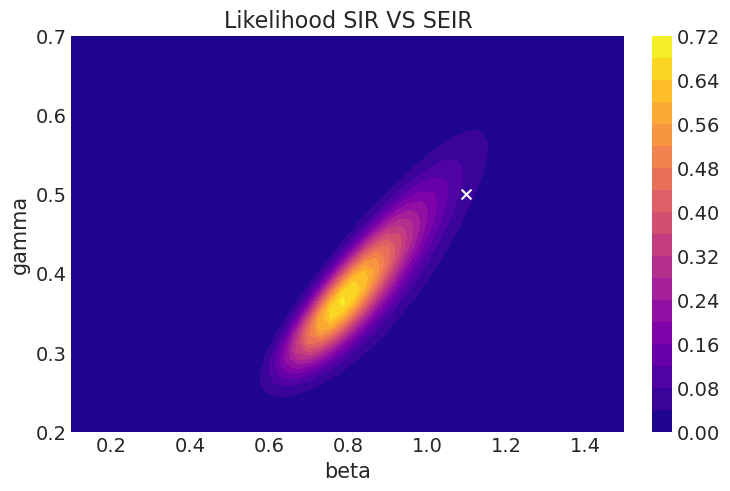

In [157]:
# Initialize forward SIR model

model_fw_SIR = Dynamical_System_Forward_SIR(days_SIR, time_step_SIR, initN_SIR, initI_SIR, initR_SIR)


# Populate a matrix with likelihood values for different beta and gamma

beta_range  = np.linspace(lower_beta,  upper_beta,  n_ref_lik)
gamma_range = np.linspace(lower_gamma, upper_gamma, n_ref_lik)

beta_test, gamma_test = np.meshgrid(beta_range,gamma_range)

loglik_test = np.ones(shape = beta_test.shape)

for i in range(len(beta_test)):
    for j in range(len(beta_test)):

        loglik_test[i][j] = my_loglik(model_fw_SIR, beta_test[i][j], gamma_test[i][j], noise_var_plot2, model_true_SEIR)

sf = plt.contourf(beta_test, gamma_test, np.exp(loglik_test), contour_lik, cmap='plasma')
plt.scatter(beta_true_SEIR,gamma_true_SEIR, marker='x', s = 50, c='white')
plt.colorbar(sf)
plt.title('Likelihood SIR VS SEIR')
plt.xlabel("beta")
plt.ylabel("gamma")
plt.show()